## 1. Overview

많은 사회 프로그램들은 적절한 사람들에게 충분한 원조를 해주는데 어려움을 겪는다. 프로그램이 인구 중 가장 가난한 계층에 초점을 맞출 때 특히 까다롭다.  
왜냐하면 세계에서 가장 가난한 사람들은 일반적으로 그들이 자격이 있다는 것을 증명하기 위해 필요한 수입과 지출 기록을 제공할 수 없기 때문이다.  
라틴 아메리카에서 한가지 인기있는 방법은 소득 자격을 검증하기 위해 알고리즘을 사용하는 방법이다.  
Proxy mean test(PMT)라고 하는데 이를 이용하여 기관들은 가족의 관찰 가능한 가구 속성을 벽이나 천장의 재료 등 가정에서 발견되는 자산을 고려하여 분류하고 그들의 필요 수준을 예측하는 모델을 사용한다.  
PMT를 개선해보자!

In [37]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

### 1.1 Core Data fields

* Id - 각 행의 고유 식별자
* Target - 소득 수준을 나타내는 순서형 변수
    - 1 = extreme poverty
    - 2 = moderate poverty
    - 3 = vulnerable households
    - 4 = non vulnerable households
* idhogar - 각 가정에 대한 고유 식별자. 이는 가구 전체의 특징 등을 만드는 데 사용할 수 있다.
* parentesco1 - 이 사람이 가장인지 아닌지 나타낸다.

## 2. Evaluation

평가지표로 macro F1 score를 사용한다.

### 2.1 Macro F1 Score

다항 분류 문제에서 두 분류의 consusion metrix을 조합해서 하나의 행렬을 만드는 작업을 한다. 이를 통해 우리는 한번에 정밀도와 재현율을 평가할 수 있는 하나의 종합적인 confusion metrix을 얻고 싶다.  
한 가지 방법은 각 confusion metrix에 대해 정밀도와 재현율을 계산하고 이들의 평균값을 계산한 것이 **macro-P, macro-R**이라 하고, 이들로 만든 F1 스코어를 **macro-F1**이라고 한다.

$$
macroP = {1 \over n}{\sum_{i=1}^nP_i}\\
macroR = {1 \over n}{\sum_{i=1}^nR_i}\\
macroF_1={{2 \times macroP \times macroR}\over{macroP+macroR}}
$$

## 3. Exploration

### 3.1 Dataset Preparation

In [38]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [39]:
train.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  ...  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
0     0  ...          100    1849               1        100             0   
1     0  ...          144    4489               1        144             0   
2     0  ...          121    8464               1          0             0   
3     0  ...           81     289              16        121             4   
4     0  ...          121    1369              16        121             4   

   SQBovercrowding  SQBdependency  SQBmeaned  agesq  Target  
0         1.000000            0.0      100.0   1849       4  
1         1.000000           64.0      144.0   4489       4  
2         0.250000           64.0      121.0   8464       4  
3         1.777778            1.0      121.0    289       4  
4         1.777778            1.0      121.0   1369       4  

[5 rows x 143 columns]

test set의 데이터크기가 더 크다...?

In [40]:
train.describe()

v2a1       hacdor        rooms       hacapo         v14a  \
count  2.697000e+03  9557.000000  9557.000000  9557.000000  9557.000000   
mean   1.652316e+05     0.038087     4.955530     0.023648     0.994768   
std    1.504571e+05     0.191417     1.468381     0.151957     0.072145   
min    0.000000e+00     0.000000     1.000000     0.000000     0.000000   
25%    8.000000e+04     0.000000     4.000000     0.000000     1.000000   
50%    1.300000e+05     0.000000     5.000000     0.000000     1.000000   
75%    2.000000e+05     0.000000     6.000000     0.000000     1.000000   
max    2.353477e+06     1.000000    11.000000     1.000000     1.000000   

            refrig         v18q        v18q1         r4h1         r4h2  ...  \
count  9557.000000  9557.000000  2215.000000  9557.000000  9557.000000  ...   
mean      0.957623     0.231767     1.404063     0.385895     1.559171  ...   
std       0.201459     0.421983     0.763131     0.680779     1.036574  ...   
min       0.000000     0.000000     1.000000     0.000000     0.000000  ...   
25%       1.000000     0.000000     1.000000     0.000000     1.000000  ...   
50%       1.000000     0.000000     1.000000     0.000000     1.000000  ...   
75%       1.000000     0.000000     2.000000     1.000000     2.000000  ...   
max       1.000000     1.000000     6.000000     5.000000     8.000000  ...   

       SQBescolari       SQBage  SQBhogar_total    SQBedjefe  SQBhogar_nin  \
count  9557.000000  9557.000000     9557.000000  9557.000000   9557.000000   
mean     74.222769  1643.774302       19.132887    53.500262      3.844826   
std      76.777549  1741.197050       18.751395    78.445804      6.946296   
min       0.000000     0.000000        1.000000     0.000000      0.000000   
25%      16.000000   289.000000        9.000000     0.000000      0.000000   
50%      36.000000   961.000000       16.000000    36.000000      1.000000   
75%     121.000000  2601.000000       25.000000    81.000000      4.000000   
max     441.000000  9409.000000      169.000000   441.000000     81.000000   

       SQBovercrowding  SQBdependency    SQBmeaned        agesq       Target  
count      9557.000000    9557.000000  9552.000000  9557.000000  9557.000000  
mean          3.249485       3.900409   102.588867  1643.774302     3.302292  
std           4.129547      12.511831    93.516890  1741.197050     1.009565  
min           0.040000       0.000000     0.000000     0.000000     1.000000  
25%           1.000000       0.111111    36.000000   289.000000     3.000000  
50%           2.250000       0.444444    81.000000   961.000000     4.000000  
75%           4.000000       1.777778   134.560010  2601.000000     4.000000  
max          36.000000      64.000000  1369.000000  9409.000000     4.000000  

[8 rows x 138 columns]

In [41]:
print ("Top Columns having missing values")
train.isna().sum().to_frame().sort_values(0, ascending=False).head()

Top Columns having missing values


0
rez_esc    7928
v18q1      7342
v2a1       6860
SQBmeaned     5
meaneduc      5

### 3.2 Different Levels of Poverty Household Groups

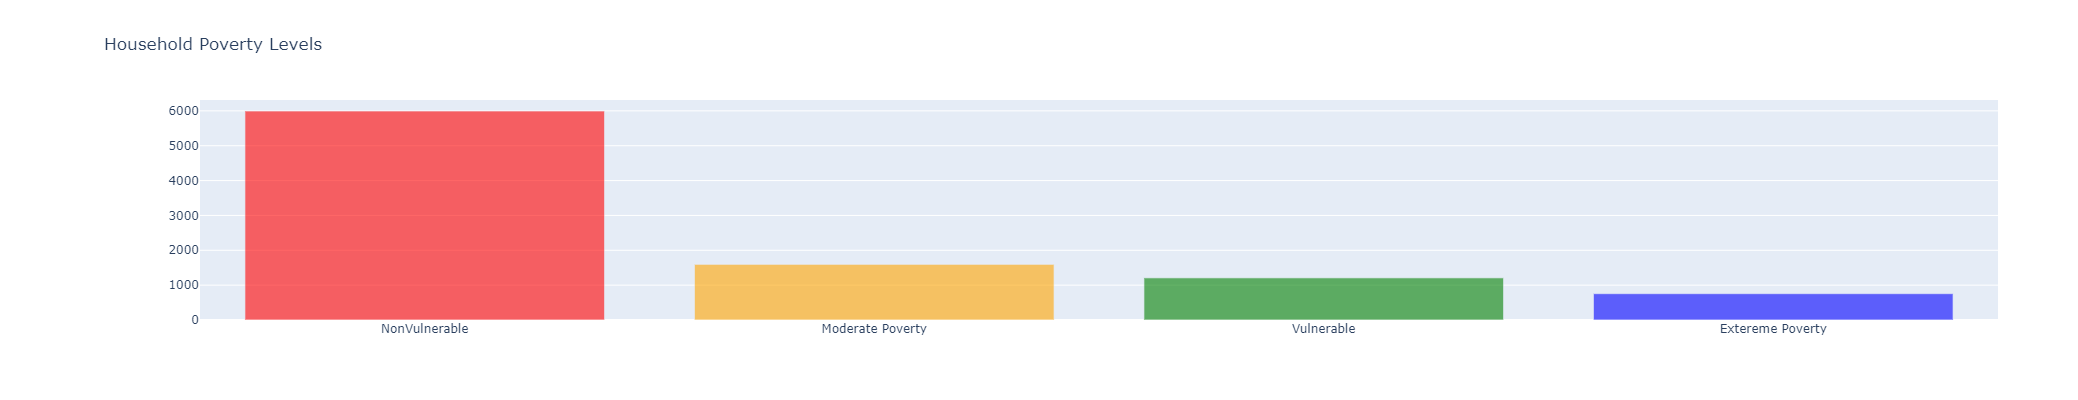

In [48]:
target = train['Target'].value_counts().to_frame()
level = ["NonVulnerable", "Moderate Poverty", "Vulnerable", "Extereme Poverty"]
trace = go.Bar(y=target.Target, x=level, marker=dict(color=['red', 'orange', 'green', 'blue'], opacity=0.6))
layout = dict(title="Household Poverty Levels", margin=dict(l=200), width=800, height=400)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### 3.3 What do households own?

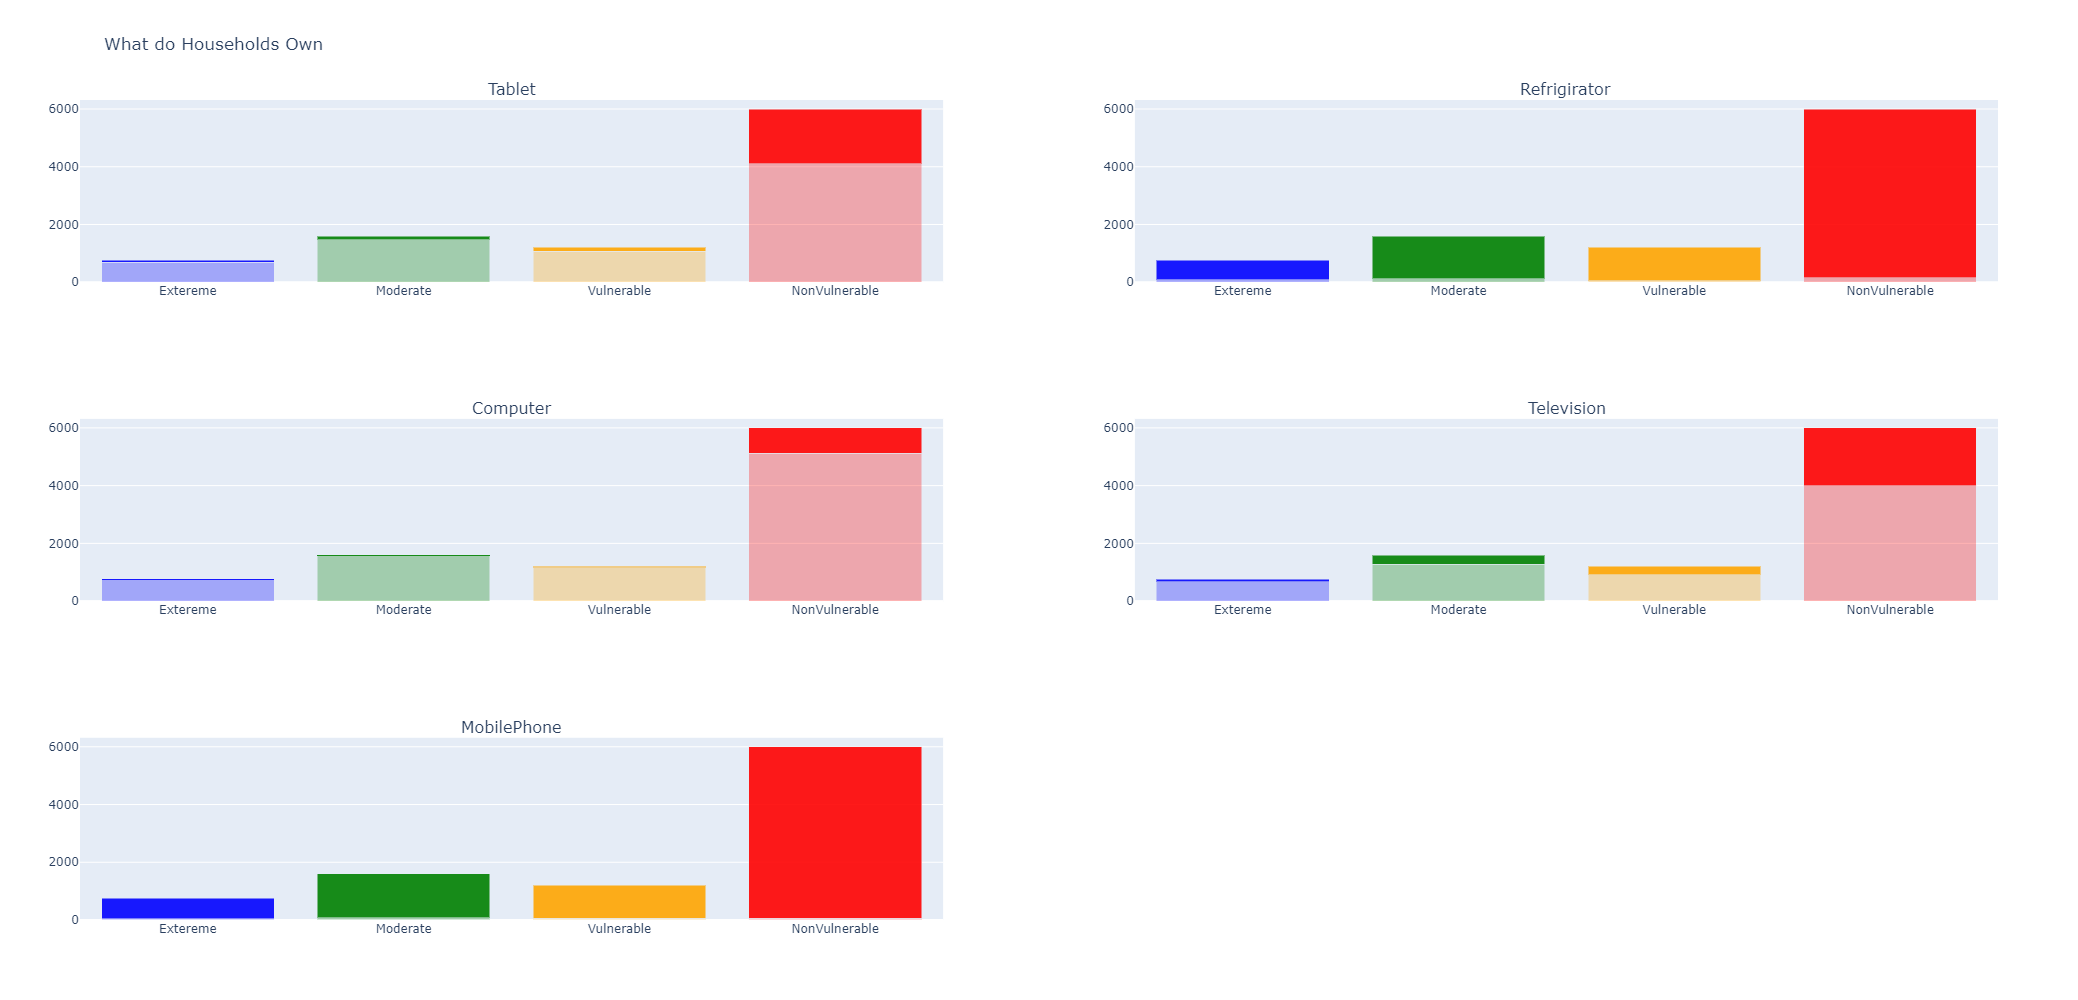

In [45]:
def compare_plot(col, title):
    tr1 = train[train['Target'] == 1][col].value_counts().to_dict()
    tr2 = train[train['Target'] == 2][col].value_counts().to_dict()
    tr3 = train[train['Target'] == 3][col].value_counts().to_dict()
    tr4 = train[train['Target'] == 4][col].value_counts().to_dict()
    
    xx = ['Extereme', 'Moderate', 'Vulnerable', 'NonVulnerable']
    trace1 = go.Bar(y=[tr1[0], tr2[0], tr3[0], tr4[0]], name='Not Present', x=xx, marker=dict(color=['blue', 'green', 'orange', 'red'], opacity=0.3))
    trace2 = go.Bar(y=[tr1[1], tr2[1], tr3[1], tr4[1]], name='Present', x=xx, marker=dict(color=['blue', 'green', 'orange', 'red'], opacity=0.9))
    
    return trace1, trace2

tr1, tr2 = compare_plot("v18q", "Tablet")
tr3, tr4 = compare_plot("refrig", "Refrigirator")
tr5, tr6 = compare_plot("computer", "Computer")
tr7, tr8 = compare_plot("television", "Television")
tr9, tr10 = compare_plot("mobilephone", "MobilePhone")
titles = ["Tablet", "Refrigirator", "Computer", "Television", "MobilePhone"]

fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 1)
fig.append_trace(tr3, 1, 2)
fig.append_trace(tr4, 1, 2)
fig.append_trace(tr5, 2, 1)
fig.append_trace(tr6, 2, 1)
fig.append_trace(tr7, 2, 2)
fig.append_trace(tr8, 2, 2)
fig.append_trace(tr9, 3, 1)
fig.append_trace(tr10, 3, 1)

fig['layout'].update(height=1000, width=1000, title="What do Households Own", barmode="stack", showlegend=False)
iplot(fig)

### 3.4 Key Charateristics of the Households

#### 3.4.1 Household Matreials and Methods

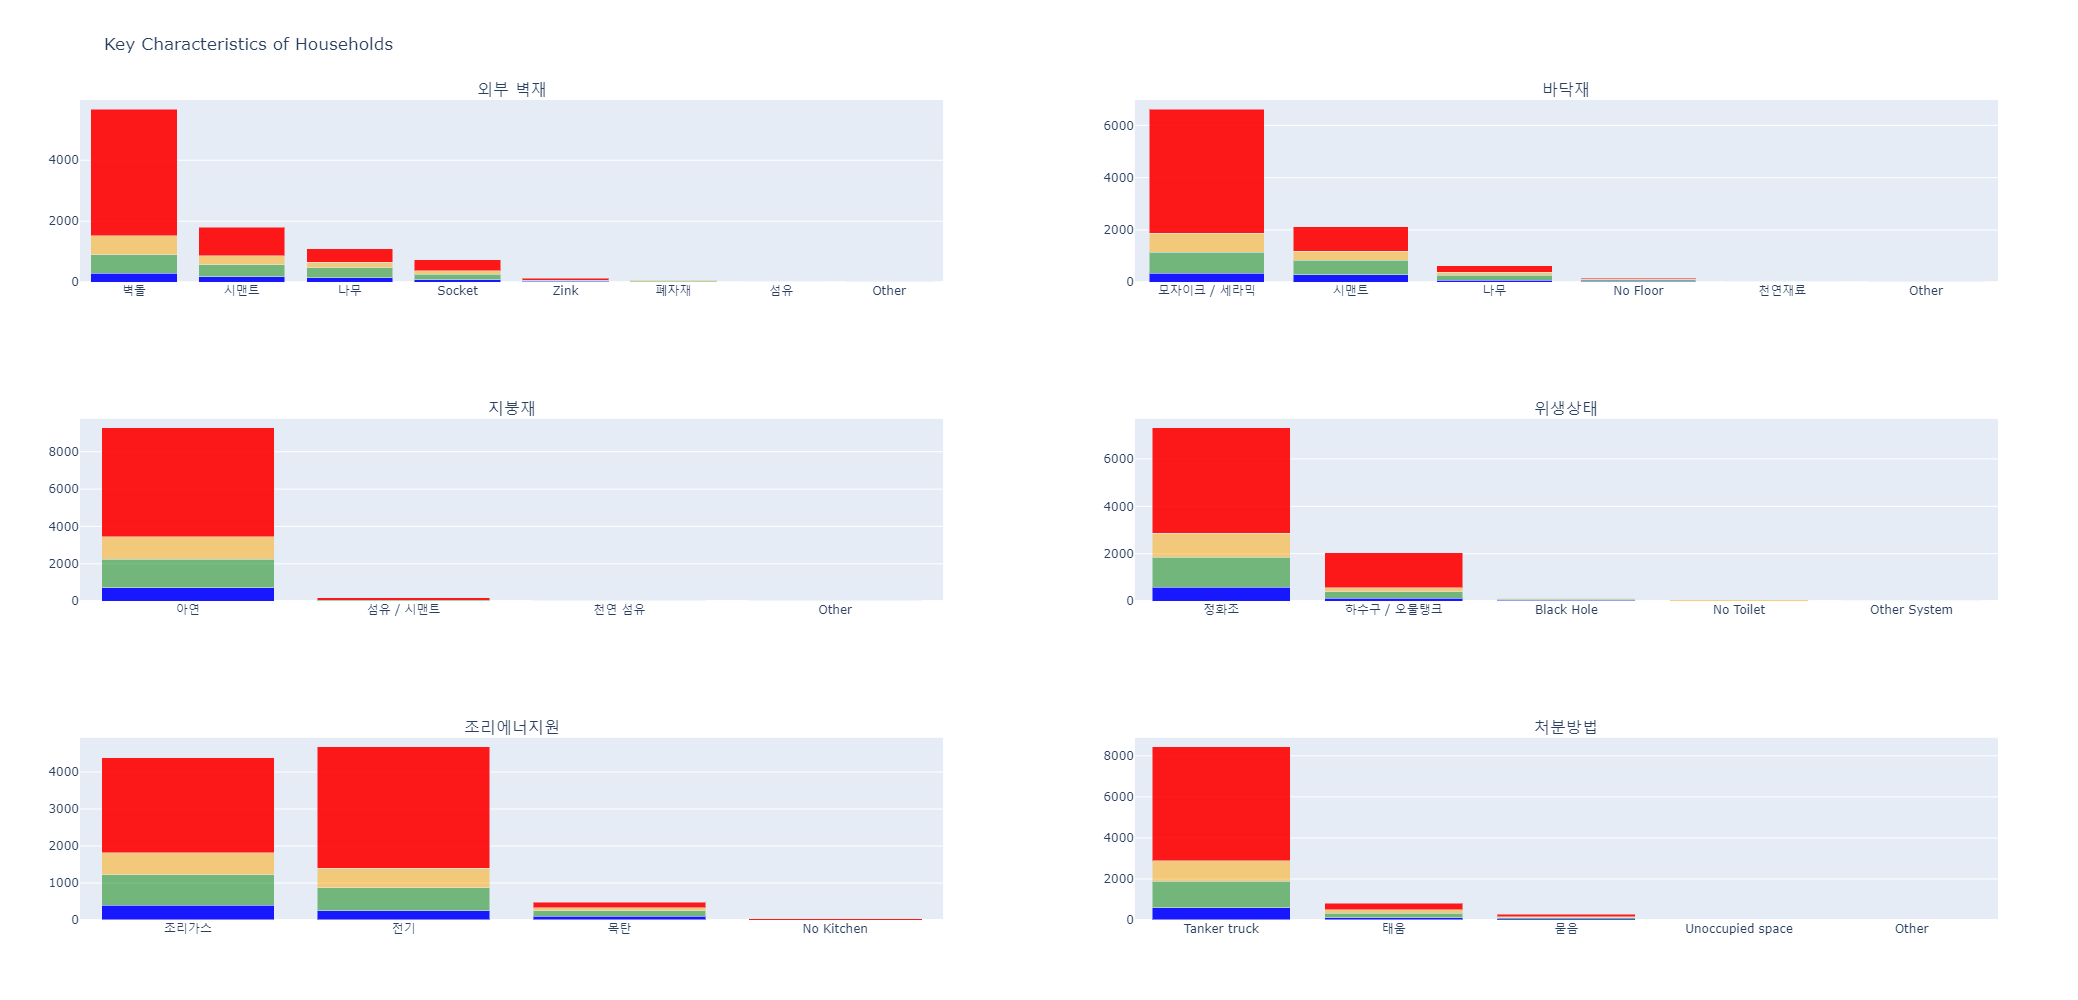

In [50]:
def find_prominent(row, mats):
    for c in mats:
        if row[c] == 1:
            return c
    return 

def combine(starter, colname, title, replacemap):
    mats = [c for c in train.columns if c.startswith(starter)]
    train[colname] = train.apply(lambda row : find_prominent(row, mats), axis=1)
    train[colname] = train[colname].apply(lambda x : replacemap[x] if x != None else x )

    om1 = train[train['Target'] == 1][colname].value_counts().to_frame()
    om2 = train[train['Target'] == 2][colname].value_counts().to_frame()
    om3 = train[train['Target'] == 3][colname].value_counts().to_frame()
    om4 = train[train['Target'] == 4][colname].value_counts().to_frame()

    trace1 = go.Bar(y=om1[colname], x=om1.index, name="Extereme", marker=dict(color='blue', opacity=0.9))
    trace2 = go.Bar(y=om2[colname], x=om2.index, name="Moderate", marker=dict(color='green', opacity=0.5))
    trace3 = go.Bar(y=om3[colname], x=om3.index, name="Vulnerable", marker=dict(color='orange', opacity=0.5))
    trace4 = go.Bar(y=om4[colname], x=om4.index, name="NonVulnerable", marker=dict(color='red', opacity=0.9))
    return [trace1, trace2, trace3, trace4]

titles = ["외부 벽재", "바닥재", "지붕재", "위생상태", "조리에너지원", "처분방법"]
fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)

### outside material
flr = {'paredblolad' : "벽돌", "paredpreb" : "시맨트", "paredmad" : "나무",
      "paredzocalo" : "Socket", "pareddes" : "폐자재", "paredfibras" : "섬유",
      "paredother" : "Other", "paredzinc": "Zink"}
res = combine("pared", "outside_material", "Predominanat Material of the External Walls", flr)      
for x in res:
    fig.append_trace(x, 1, 1)

### floor material 
flr = {'pisomoscer' : "모자이크 / 세라믹", "pisocemento" : "시맨트", "pisonatur" : "천연재료",
      "pisonotiene" : "No Floor", "pisomadera" : "나무", "pisoother" : "Other"}
res = combine("piso", "floor_material", "Floor Material of the Households", flr)
for x in res:
    fig.append_trace(x, 1, 2)

### Roof Material
flr = {'techozinc' : "아연", "techoentrepiso" : "섬유 / 시맨트", "techocane" : "천연 섬유", "techootro" : "Other"}
res = combine("tech", "roof_material", "Roof Material of the Households", flr)  
for x in res:
    fig.append_trace(x, 2, 1)


### Sanitary Conditions
flr = {'sanitario1' : "No Toilet", "sanitario2" : "하수구 / 오물탱크", "sanitario3" : "정화조",
       "sanitario5" : "Black Hole", "sanitario6" : "Other System"}
res = combine("sanit", "sanitary", "Sanitary Conditions of the Households", flr)
for x in res:
    fig.append_trace(x, 2, 2)

### Energy Source
flr = {'energcocinar1' : "No Kitchen", "energcocinar2" : "전기", "energcocinar3" : "조리가스",
       "energcocinar4" : "목탄"}
res = combine("energ", "energy_source", "Main source of energy for cooking", flr)  
for x in res:
    fig.append_trace(x, 3, 1)

### Disposal Methods
flr = {"elimbasu1":"Tanker truck",
"elimbasu2": "묻음",
"elimbasu3": "태움",
"elimbasu4": "Unoccupied space",
"elimbasu5": "강",
"elimbasu6": "Other"}
res = combine("elim", "waste_method", "Rubbish Disposals Method", flr)  
for x in res:
    fig.append_trace(x, 3, 2)

fig['layout'].update(height=1000, width=1000, title="Key Characteristics of Households", barmode="stack", showlegend=False)
iplot(fig)

#### 3.4.2 Quality of Walls, Roofs, and Floor

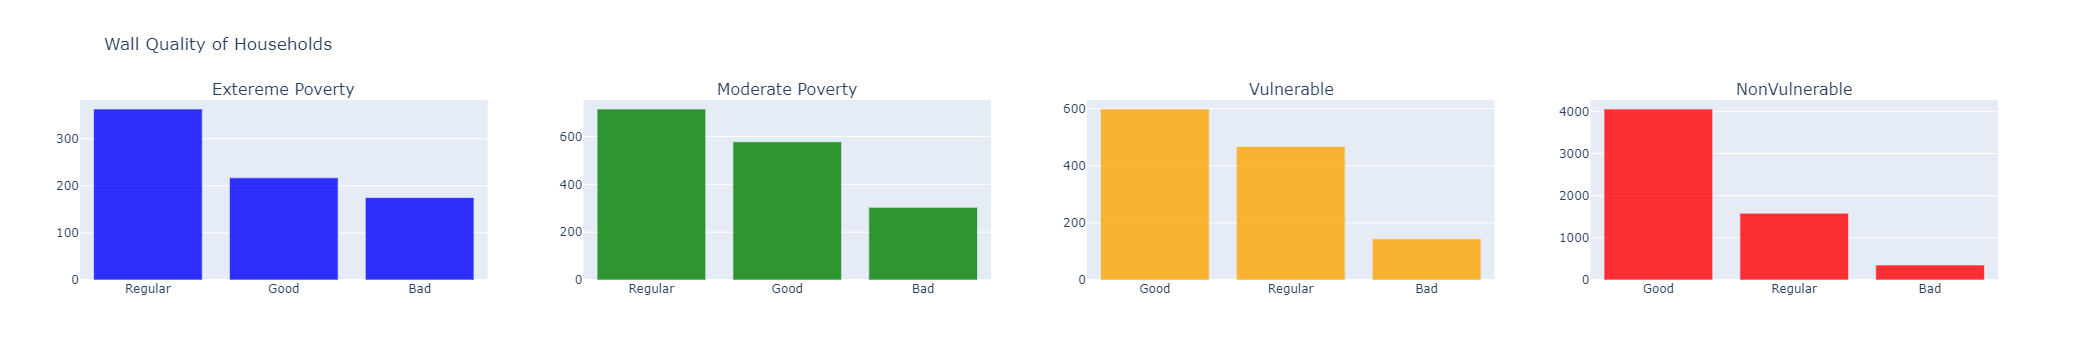

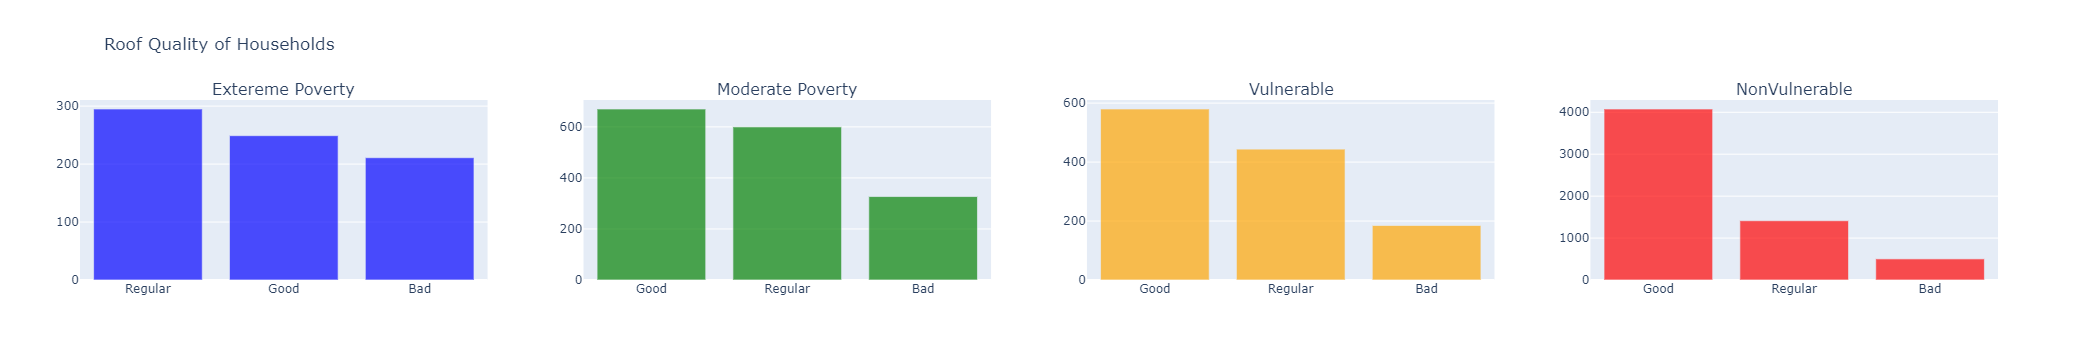

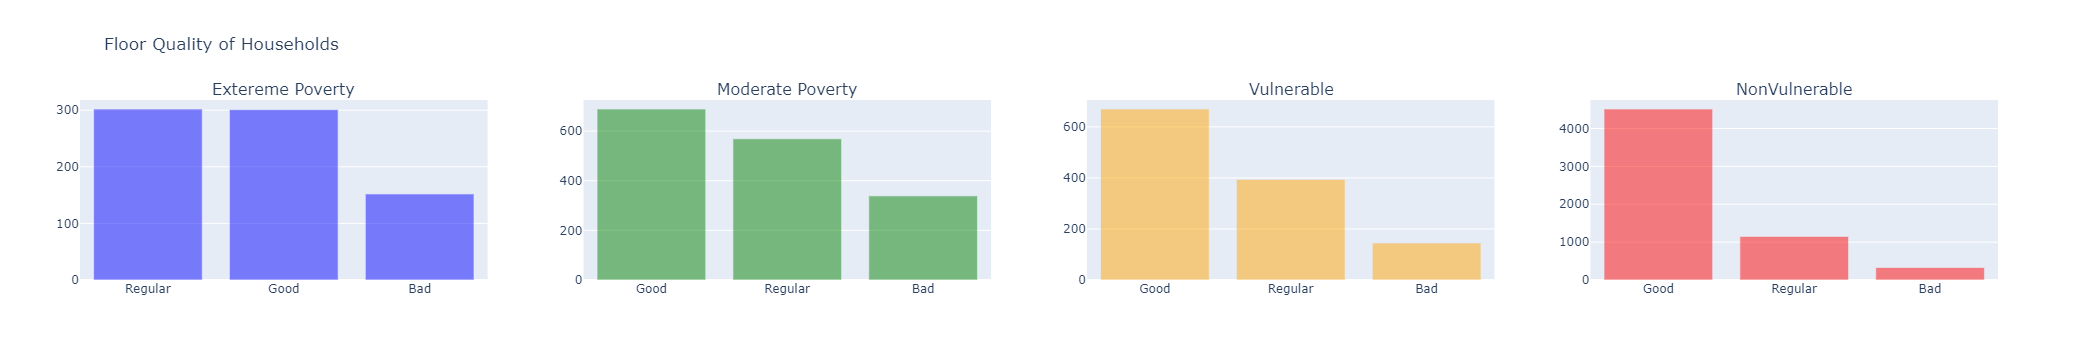

In [9]:
def find_prominent2(row, mats):
    for i, c in enumerate(mats):
        if row[c] == 1 and c.endswith('1'):
            return 'Bad'
        elif row[c] == 1 and c.endswith("2"):
            return "Regular"
        elif row[c] == 1 and c.endswith("3"):
            return "Good"
    return 

badwl = [c for c in train.columns if c.startswith('epar')]
badrf = [c for c in train.columns if c.startswith('etec')]
badfl = [c for c in train.columns if c.startswith('eviv')]

train['WallQuality'] = train.apply(lambda row: find_prominent2(row, badwl), axis=1)
train["RoofQuality"] = train.apply(lambda row : find_prominent2(row, badrf), axis=1)
train["FloorQuality"] = train.apply(lambda row : find_prominent2(row, badfl), axis=1)

wd1 = train[train['Target']==1]['WallQuality'].value_counts()
wd2 = train[train['Target']==2]['WallQuality'].value_counts()
wd3 = train[train['Target']==3]['WallQuality'].value_counts()
wd4 = train[train['Target']==4]['WallQuality'].value_counts()

trace1=go.Bar(x=wd1.index, y=wd1.values, marker=dict(color="blue", opacity=0.8), name="Extereme")
trace2=go.Bar(x=wd2.index, y=wd2.values, marker=dict(color="green", opacity=0.8), name="Moderate")
trace3=go.Bar(x=wd3.index, y=wd3.values, marker=dict(color="orange", opacity=0.8), name="Vulnerable")
trace4=go.Bar(x=wd4.index, y=wd4.values, marker=dict(color="red", opacity=0.8), name="NonVulnerable")

rf1 = train[train['Target']==1]['RoofQuality'].value_counts()
rf2 = train[train['Target']==2]['RoofQuality'].value_counts()
rf3 = train[train['Target']==3]['RoofQuality'].value_counts()
rf4 = train[train['Target']==4]['RoofQuality'].value_counts()

trace5=go.Bar(x=rf1.index, y=rf1.values, marker=dict(color="blue", opacity=0.69), name="Extereme")
trace6=go.Bar(x=rf2.index, y=rf2.values, marker=dict(color="green", opacity=0.69), name="Moderate")
trace7=go.Bar(x=rf3.index, y=rf3.values, marker=dict(color="orange", opacity=0.69), name="Vulnerable")
trace8=go.Bar(x=rf4.index, y=rf4.values, marker=dict(color="red", opacity=0.69), name="NonVulnerable")

fl1 = train[train['Target']==1]['FloorQuality'].value_counts()
fl2 = train[train['Target']==2]['FloorQuality'].value_counts()
fl3 = train[train['Target']==3]['FloorQuality'].value_counts()
fl4 = train[train['Target']==4]['FloorQuality'].value_counts()

trace9=go.Bar(x=fl1.index, y=fl1.values, marker=dict(color="blue", opacity=0.49), name="Extereme")
trace10=go.Bar(x=fl2.index, y=fl2.values, marker=dict(color="green", opacity=0.49), name="Moderate")
trace11=go.Bar(x=fl3.index, y=fl3.values, marker=dict(color="orange", opacity=0.49), name="Vulnerable")
trace12=go.Bar(x=fl4.index, y=fl4.values, marker=dict(color="red", opacity=0.49), name="NonVulnerable")

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig['layout'].update(height=300,width=1000, showlegend=False, title="Wall Quality of Households")
iplot(fig)

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 2)
fig.append_trace(trace7, 1, 3)
fig.append_trace(trace8, 1, 4)
fig['layout'].update(height=300,width=1000, showlegend=False, title="Roof Quality of Households")
iplot(fig)

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace9, 1, 1)
fig.append_trace(trace10, 1, 2)
fig.append_trace(trace11, 1, 3)
fig.append_trace(trace12, 1, 4)
fig['layout'].update(height=300,width=1000, showlegend=False, title="Floor Quality of Households")
iplot(fig)

### 3.5 Family Details of the housholds

#### 3.5.1 Education Details, Status, and Members

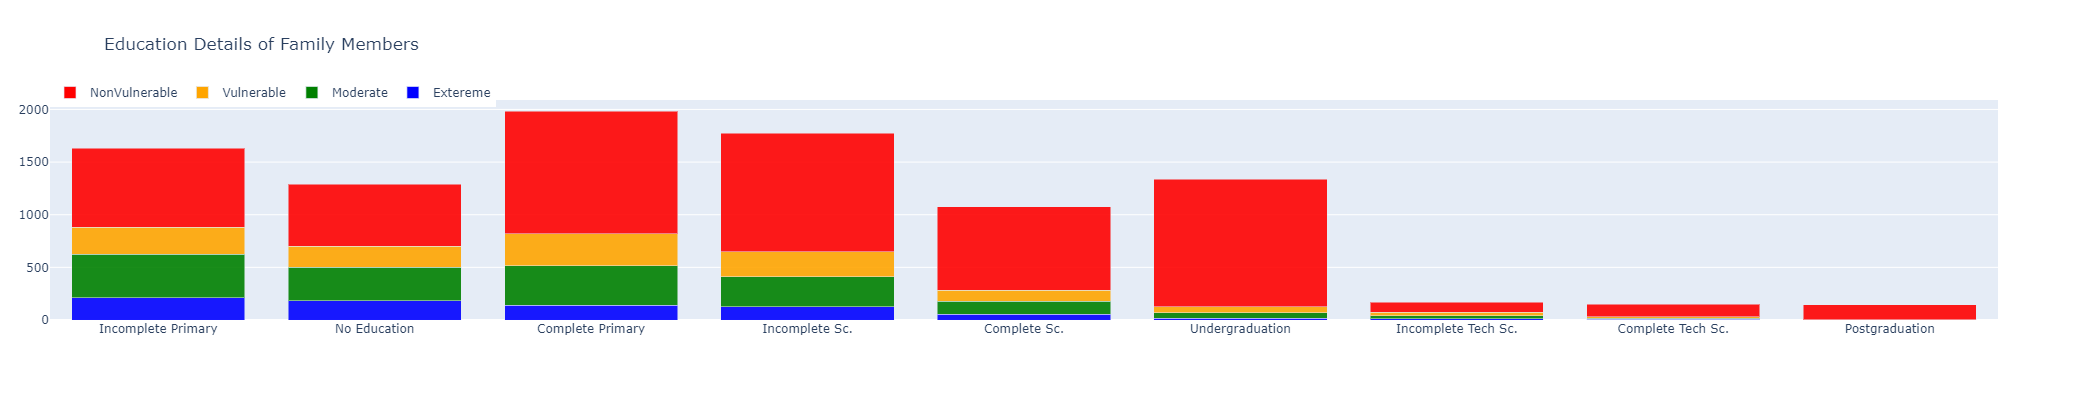

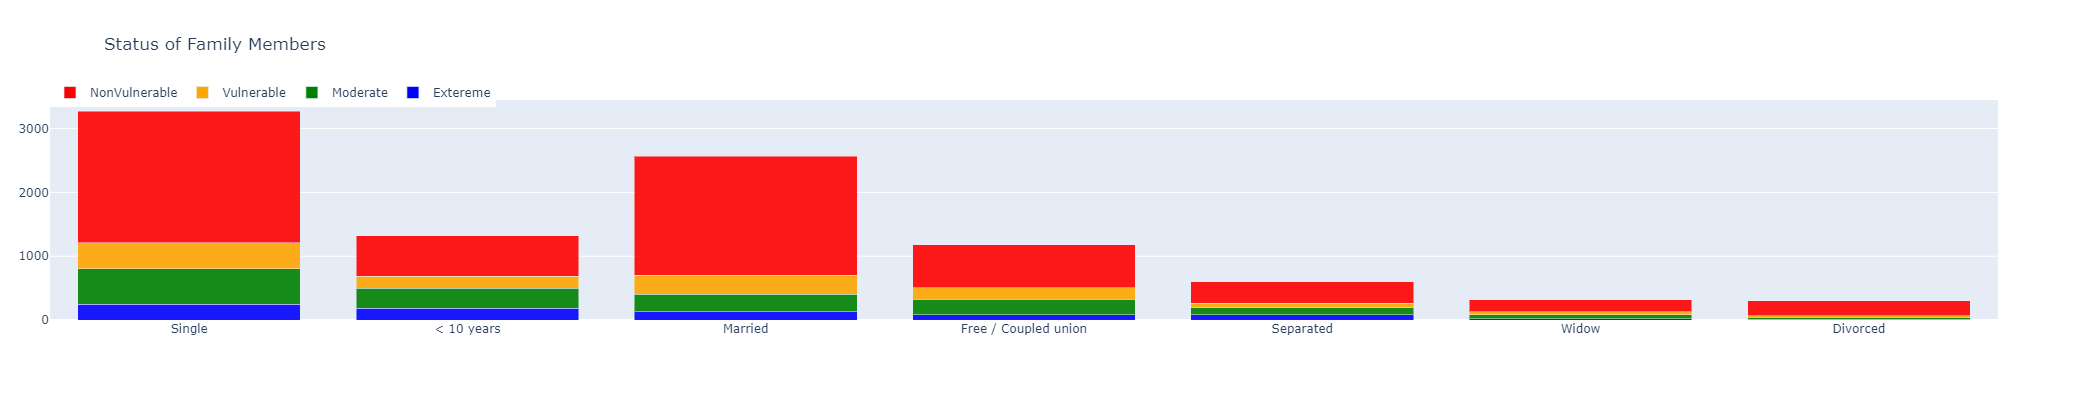

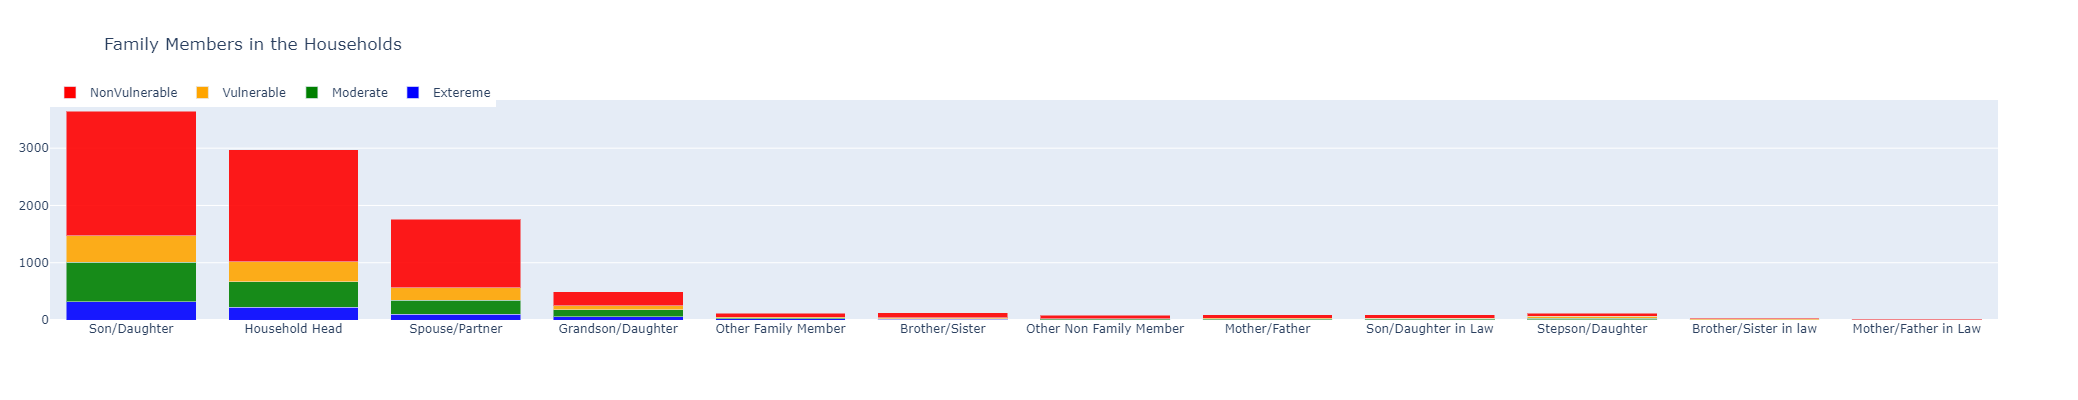

In [53]:
def combine2(starter, colname, title, replacemap, plotme = True):
    mats = [c for c in train.columns if c.startswith(starter)]
    train[colname] = train.apply(lambda row : find_prominent(row, mats), axis=1)
    train[colname] = train[colname].apply(lambda x : replacemap[x] if x != None else x )

    om1 = train[train['Target'] == 1][colname].value_counts().to_frame()
    om2 = train[train['Target'] == 2][colname].value_counts().to_frame()
    om3 = train[train['Target'] == 3][colname].value_counts().to_frame()
    om4 = train[train['Target'] == 4][colname].value_counts().to_frame()

    trace1 = go.Bar(y=om1[colname], x=om1.index, name="Extereme", marker=dict(color='blue', opacity=0.9))
    trace2 = go.Bar(y=om2[colname], x=om2.index, name="Moderate", marker=dict(color='green', opacity=0.9))
    trace3 = go.Bar(y=om3[colname], x=om3.index, name="Vulnerable", marker=dict(color='orange', opacity=0.9))
    trace4 = go.Bar(y=om4[colname], x=om4.index, name="NonVulnerable", marker=dict(color='red', opacity=0.9))

    data = [trace1, trace2, trace3, trace4]
    layout = dict(title=title, legend=dict(y=1.1, orientation="h"), barmode="stack", margin=dict(l=50), height=400, width=1000)
    fig = go.Figure(data=data, layout=layout)
    if plotme:
        iplot(fig)


flr = {"instlevel1": "No Education", "instlevel2": "Incomplete Primary", "instlevel3": "Complete Primary", 
       "instlevel4": "Incomplete Sc.", "instlevel5": "Complete Sc.", "instlevel6": "Incomplete Tech Sc.",
       "instlevel7": "Complete Tech Sc.", "instlevel8": "Undergraduation", "instlevel9": "Postgraduation"}
combine2("instl", "education_details", "Education Details of Family Members", flr)  

flr = {"estadocivil1": "< 10 years", "estadocivil2": "Free / Coupled union", "estadocivil3": "Married", 
       "estadocivil4": "Divorced", "estadocivil5": "Separated", "estadocivil6": "Widow",
       "estadocivil7": "Single"}
combine2("estado", "status_members", "Status of Family Members", flr)  

flr = {"parentesco1": "Household Head", "parentesco2": "Spouse/Partner", "parentesco3": "Son/Daughter", 
       "parentesco4": "Stepson/Daughter", "parentesco5" : "Son/Daughter in Law" , "parentesco6": "Grandson/Daughter", 
       "parentesco7": "Mother/Father", "parentesco8": "Mother/Father in Law", "parentesco9" : "Brother/Sister" , 
       "parentesco10" : "Brother/Sister in law", "parentesco11" : "Other Family Member", "parentesco12" : "Other Non Family Member"}
combine2("parentesc", "family_members", "Family Members in the Households", flr)  

flr = {"lugar1": "Central", "lugar2": "Chorotega", "lugar3": "PacÃƒÂ­fico central", 
       "lugar4": "Brunca", "lugar5": "Huetar AtlÃƒÂ¡ntica", "lugar6": "Huetar Norte"}
combine2("lugar", "region", "Region of the Households", flr, plotme=False)

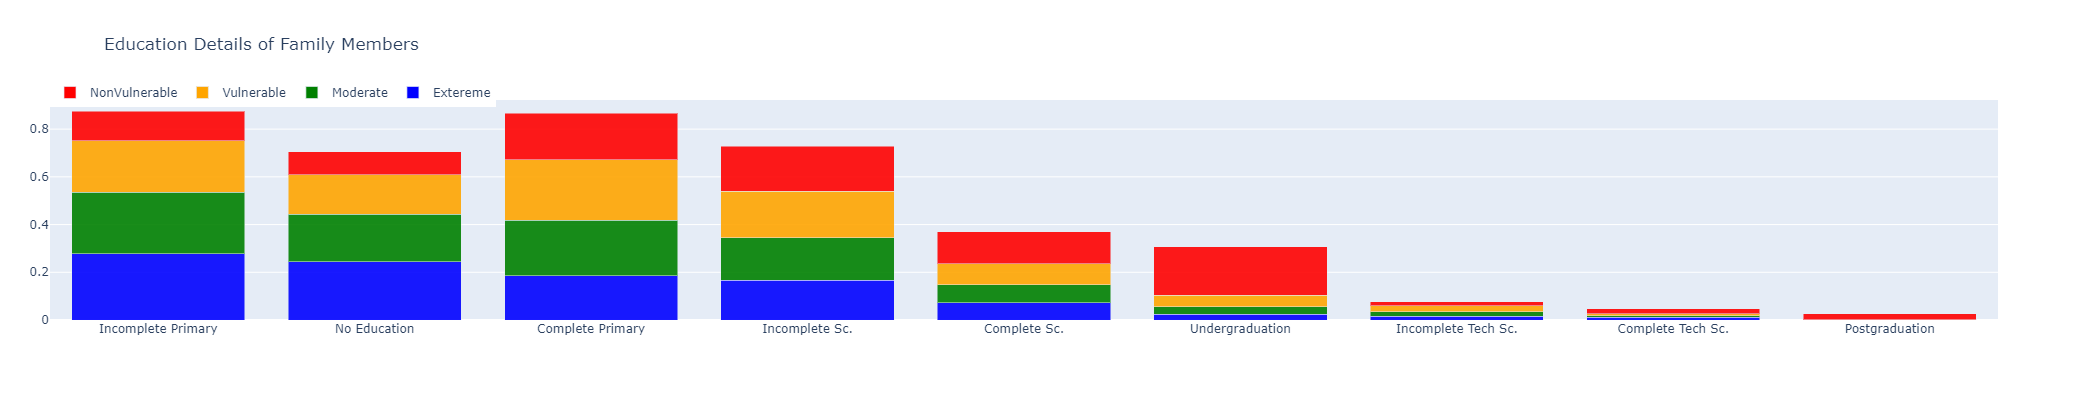

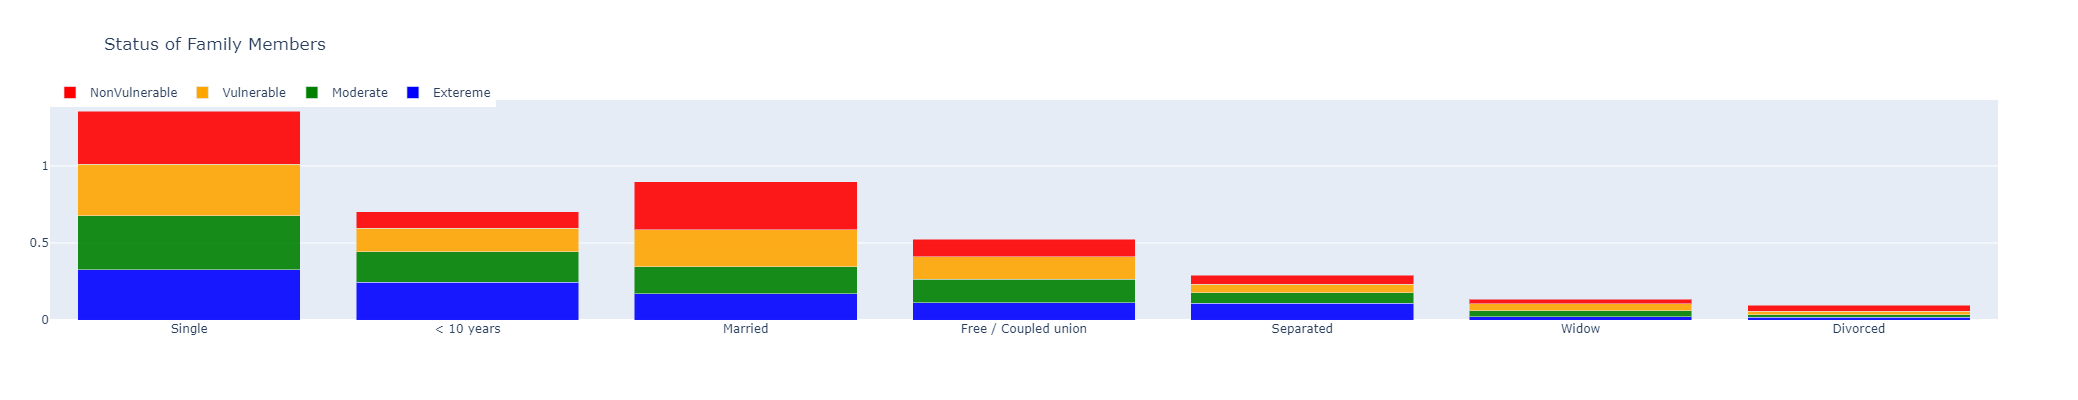

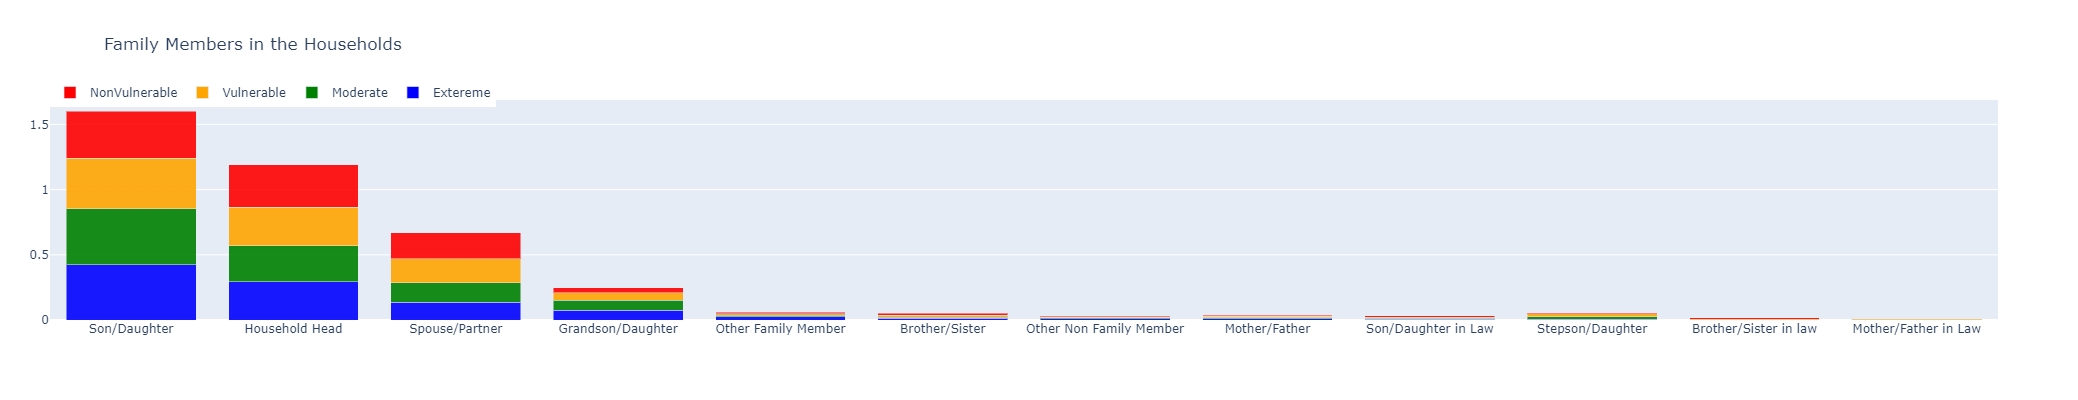

In [54]:
def combine2(starter, colname, title, replacemap, plotme = True):
    mats = [c for c in train.columns if c.startswith(starter)]
    train[colname] = train.apply(lambda row : find_prominent(row, mats), axis=1)
    train[colname] = train[colname].apply(lambda x : replacemap[x] if x != None else x )

    om1 = train[train['Target'] == 1][colname].value_counts(normalize=True).to_frame()
    om2 = train[train['Target'] == 2][colname].value_counts(normalize=True).to_frame()
    om3 = train[train['Target'] == 3][colname].value_counts(normalize=True).to_frame()
    om4 = train[train['Target'] == 4][colname].value_counts(normalize=True).to_frame()

    trace1 = go.Bar(y=om1[colname], x=om1.index, name="Extereme", marker=dict(color='blue', opacity=0.9))
    trace2 = go.Bar(y=om2[colname], x=om2.index, name="Moderate", marker=dict(color='green', opacity=0.9))
    trace3 = go.Bar(y=om3[colname], x=om3.index, name="Vulnerable", marker=dict(color='orange', opacity=0.9))
    trace4 = go.Bar(y=om4[colname], x=om4.index, name="NonVulnerable", marker=dict(color='red', opacity=0.9))

    data = [trace1, trace2, trace3, trace4]
    layout = dict(title=title, legend=dict(y=1.1, orientation="h"), barmode="stack", margin=dict(l=50), height=400, width=1000)
    fig = go.Figure(data=data, layout=layout)
    if plotme:
        iplot(fig)


flr = {"instlevel1": "No Education", "instlevel2": "Incomplete Primary", "instlevel3": "Complete Primary", 
       "instlevel4": "Incomplete Sc.", "instlevel5": "Complete Sc.", "instlevel6": "Incomplete Tech Sc.",
       "instlevel7": "Complete Tech Sc.", "instlevel8": "Undergraduation", "instlevel9": "Postgraduation"}
combine2("instl", "education_details", "Education Details of Family Members", flr)  

flr = {"estadocivil1": "< 10 years", "estadocivil2": "Free / Coupled union", "estadocivil3": "Married", 
       "estadocivil4": "Divorced", "estadocivil5": "Separated", "estadocivil6": "Widow",
       "estadocivil7": "Single"}
combine2("estado", "status_members", "Status of Family Members", flr)  

flr = {"parentesco1": "Household Head", "parentesco2": "Spouse/Partner", "parentesco3": "Son/Daughter", 
       "parentesco4": "Stepson/Daughter", "parentesco5" : "Son/Daughter in Law" , "parentesco6": "Grandson/Daughter", 
       "parentesco7": "Mother/Father", "parentesco8": "Mother/Father in Law", "parentesco9" : "Brother/Sister" , 
       "parentesco10" : "Brother/Sister in law", "parentesco11" : "Other Family Member", "parentesco12" : "Other Non Family Member"}
combine2("parentesc", "family_members", "Family Members in the Households", flr)  

flr = {"lugar1": "Central", "lugar2": "Chorotega", "lugar3": "PacÃƒÂ­fico central", 
       "lugar4": "Brunca", "lugar5": "Huetar AtlÃƒÂ¡ntica", "lugar6": "Huetar Norte"}
combine2("lugar", "region", "Region of the Households", flr, plotme=False)

#### 3.5.2 Gender and Age Distributions

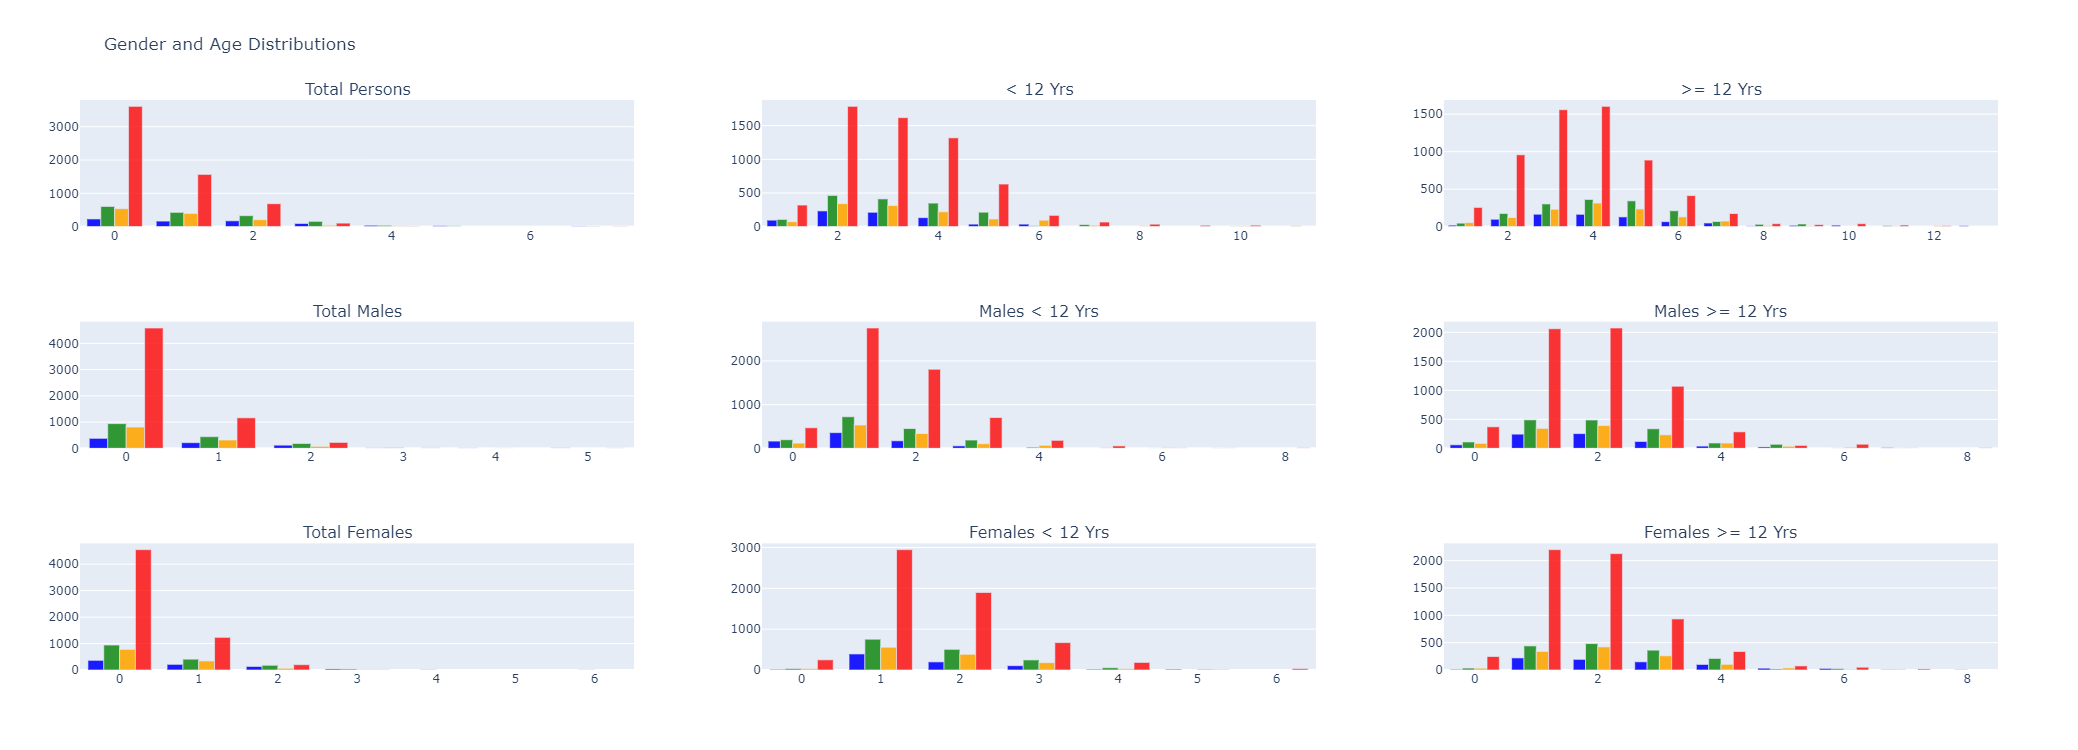

In [11]:
def agbr(col):
    temp1 = train[train['Target'] == 1][col].value_counts()
    trace1 = go.Bar(x=temp1.index, y=temp1.values, marker=dict(color="blue", opacity=0.89), name="Extereme")

    temp2 = train[train['Target'] == 2][col].value_counts()
    trace2 = go.Bar(x=temp2.index, y=temp2.values, marker=dict(color="green", opacity=0.79), name="Moderate")

    temp3 = train[train['Target'] == 3][col].value_counts()
    trace3 = go.Bar(x=temp3.index, y=temp3.values, marker=dict(color="orange", opacity=0.89), name="Vulnerable")

    temp4 = train[train['Target'] == 4][col].value_counts()
    trace4 = go.Bar(x=temp4.index, y=temp4.values, marker=dict(color="red", opacity=0.79), name="NonVulnerable")
    
    return [trace1, trace2, trace3, trace4]
    layout = dict(height=400)
    fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
    iplot(fig)

titles = ["Total Persons", "< 12 Yrs", ">= 12 Yrs", "Total Males", "Males < 12 Yrs", "Males >= 12 Yrs", 
         "Total Females", "Females < 12 Yrs", "Females >= 12 Yrs"]
fig = tools.make_subplots(rows=3, cols=3, print_grid=False, subplot_titles=titles)

res = agbr('r4t1')
for x in res:
    fig.append_trace(x, 1, 1)
res = agbr('r4t2')
for x in res:
    fig.append_trace(x, 1, 2)
res = agbr('r4t3')
for x in res:
    fig.append_trace(x, 1, 3)

res = agbr('r4h1')
for x in res:
    fig.append_trace(x, 2, 1)
res = agbr('r4h2')
for x in res:
    fig.append_trace(x, 2, 2)
res = agbr('r4h3')
for x in res:
    fig.append_trace(x, 2, 3)

res = agbr('r4m1')
for x in res:
    fig.append_trace(x, 3, 1)
res = agbr('r4m2')
for x in res:
    fig.append_trace(x, 3, 2)
res = agbr('r4m3')
for x in res:
    fig.append_trace(x, 3, 3)

    
fig['layout'].update(height=750,width=1500, showlegend=False, title="Gender and Age Distributions")
iplot(fig)

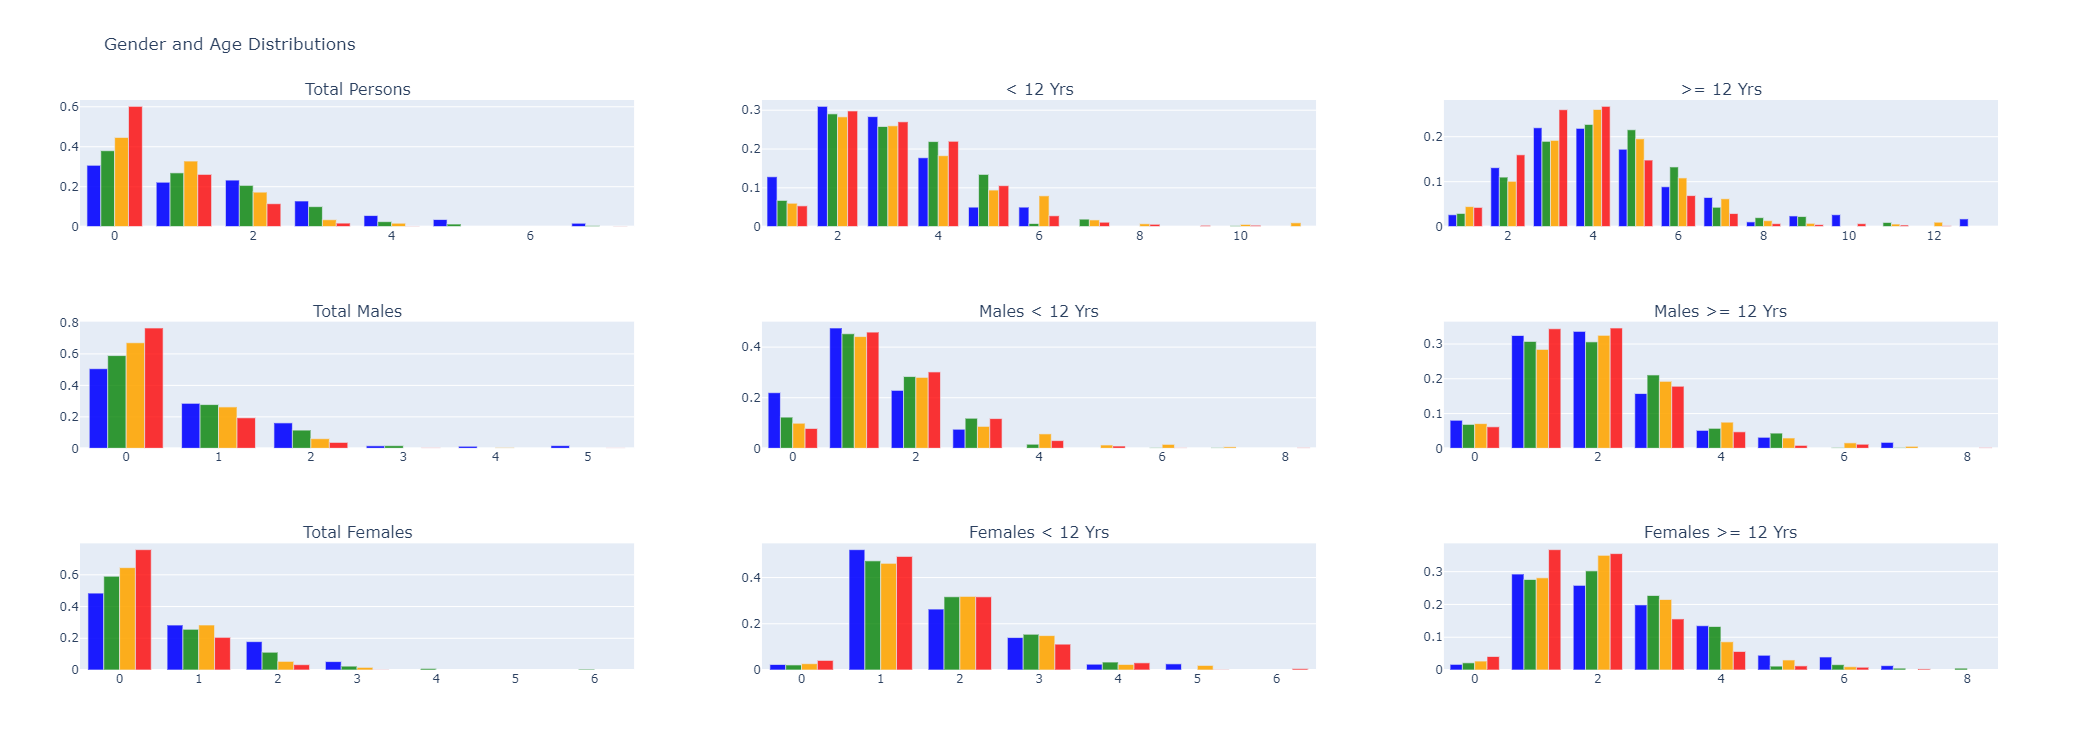

In [55]:
def agbr(col):
    temp1 = train[train['Target'] == 1][col].value_counts(normalize=True)
    trace1 = go.Bar(x=temp1.index, y=temp1.values, marker=dict(color="blue", opacity=0.89), name="Extereme")

    temp2 = train[train['Target'] == 2][col].value_counts(normalize=True)
    trace2 = go.Bar(x=temp2.index, y=temp2.values, marker=dict(color="green", opacity=0.79), name="Moderate")

    temp3 = train[train['Target'] == 3][col].value_counts(normalize=True)
    trace3 = go.Bar(x=temp3.index, y=temp3.values, marker=dict(color="orange", opacity=0.89), name="Vulnerable")

    temp4 = train[train['Target'] == 4][col].value_counts(normalize=True)
    trace4 = go.Bar(x=temp4.index, y=temp4.values, marker=dict(color="red", opacity=0.79), name="NonVulnerable")
    
    return [trace1, trace2, trace3, trace4]
    layout = dict(height=400)
    fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
    iplot(fig)

titles = ["Total Persons", "< 12 Yrs", ">= 12 Yrs", "Total Males", "Males < 12 Yrs", "Males >= 12 Yrs", 
         "Total Females", "Females < 12 Yrs", "Females >= 12 Yrs"]
fig = tools.make_subplots(rows=3, cols=3, print_grid=False, subplot_titles=titles)

res = agbr('r4t1')
for x in res:
    fig.append_trace(x, 1, 1)
res = agbr('r4t2')
for x in res:
    fig.append_trace(x, 1, 2)
res = agbr('r4t3')
for x in res:
    fig.append_trace(x, 1, 3)

res = agbr('r4h1')
for x in res:
    fig.append_trace(x, 2, 1)
res = agbr('r4h2')
for x in res:
    fig.append_trace(x, 2, 2)
res = agbr('r4h3')
for x in res:
    fig.append_trace(x, 2, 3)

res = agbr('r4m1')
for x in res:
    fig.append_trace(x, 3, 1)
res = agbr('r4m2')
for x in res:
    fig.append_trace(x, 3, 2)
res = agbr('r4m3')
for x in res:
    fig.append_trace(x, 3, 3)

    
fig['layout'].update(height=750,width=1500, showlegend=False, title="Gender and Age Distributions")
iplot(fig)

#### 3.5.3 Age Groups among the households

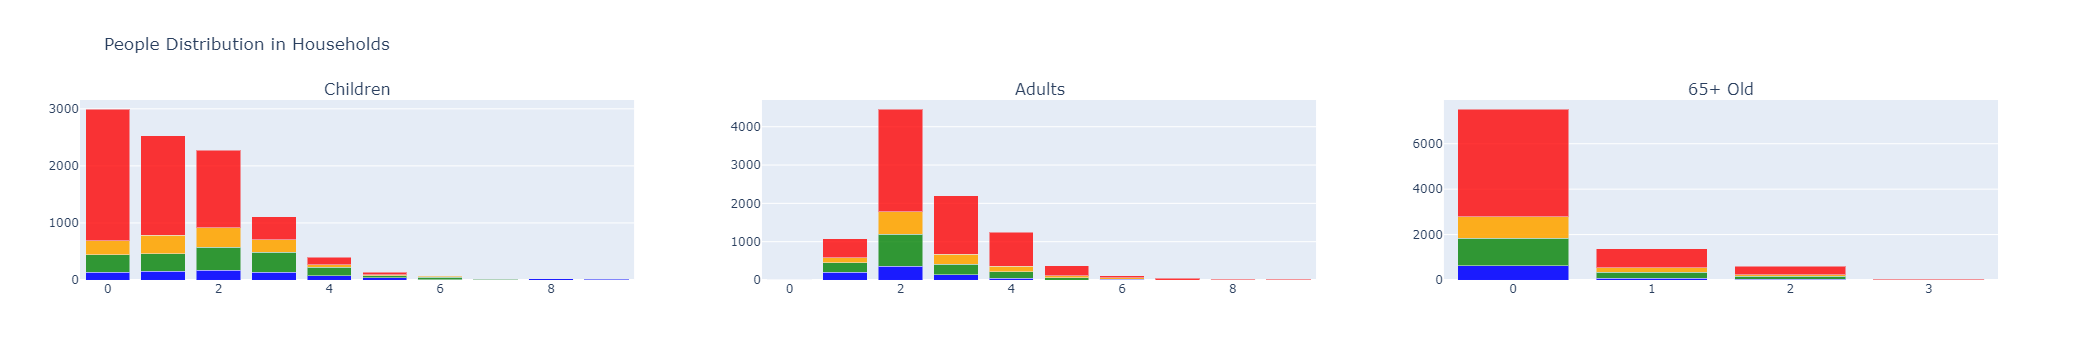

In [12]:
titles = ["Children", "Adults", "65+ Old"]
fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles=titles)

res = agbr("hogar_nin")
for x in res:
    fig.append_trace(x, 1, 1)
res = agbr("hogar_adul")
for x in res:
    fig.append_trace(x, 1, 2)
res = agbr("hogar_mayor")
for x in res:
    fig.append_trace(x, 1, 3)

fig['layout'].update(height=350, width=1000, title="People Distribution in Households", barmode="stack", showlegend=False)
iplot(fig)

#### 3.5.4 Household Size

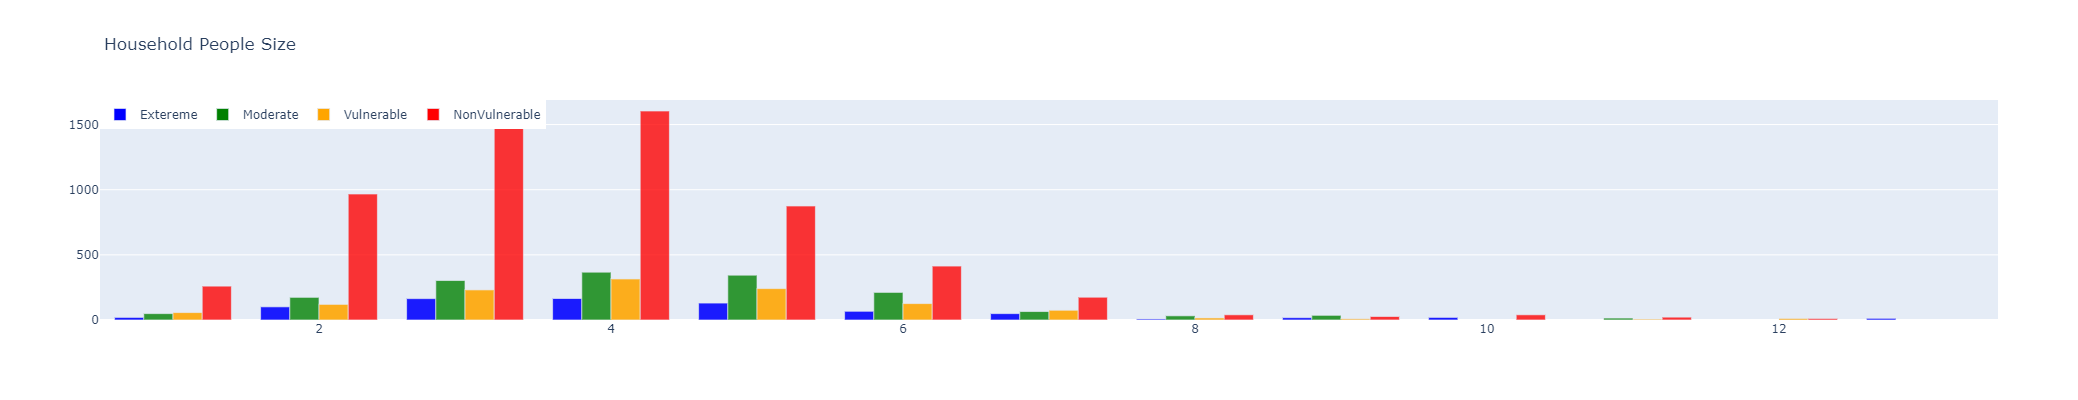

In [13]:
tm = agbr('tamhog')
layout = dict(title="Household People Size", margin=dict(l=100), height=400, width=1000, legend=dict(orientation="h", y=1))
fig = go.Figure(data=tm, layout=layout)
iplot(fig)

### 3.6 Multivariate Analysis

#### 3.6.1 Monthly Rent Comparisons

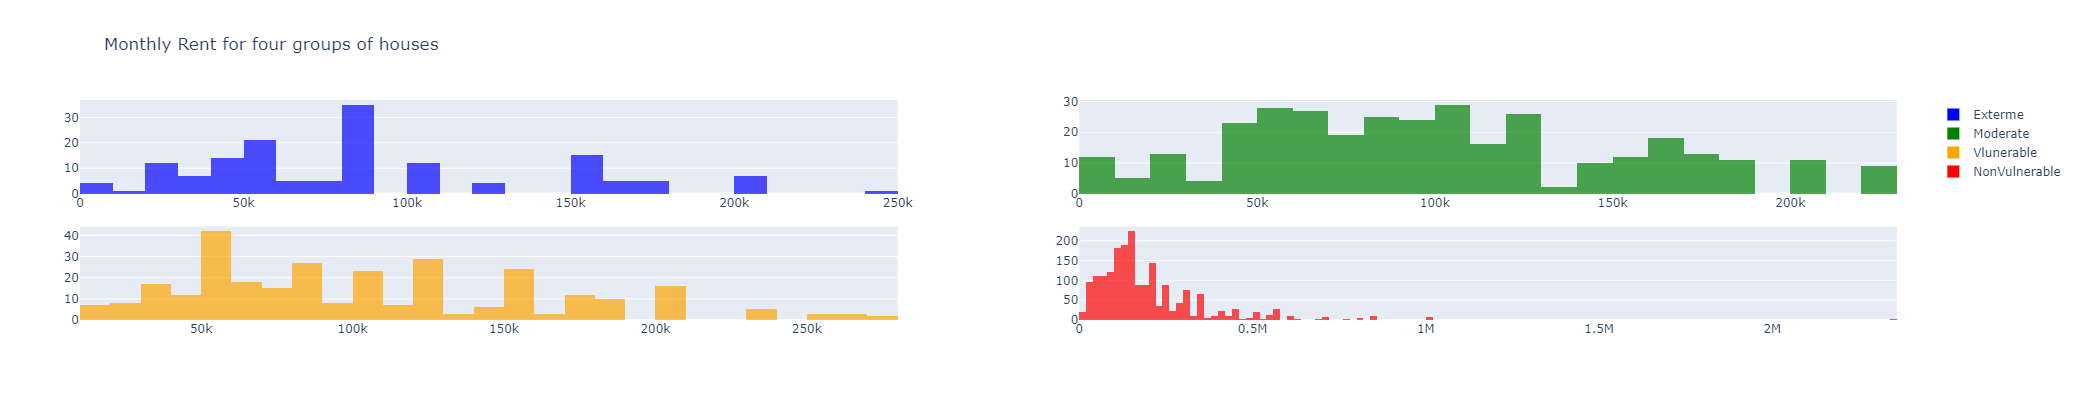

In [14]:
def compare_dists(col, title):
    trace1 = go.Histogram(name = 'Exterme', x = train[train['Target']==1][col], marker=dict(color="blue", opacity=0.69))
    trace2 = go.Histogram(name = 'Moderate', x = train[train['Target']==2][col], marker=dict(color="green", opacity=0.69))
    trace3 = go.Histogram(name = 'Vlunerable', x = train[train['Target']==3][col], marker=dict(color="orange", opacity=0.69))
    trace4 = go.Histogram(name = 'NonVulnerable', x = train[train['Target']==4][col], marker=dict(color="red", opacity=0.69))
    
    fig = tools.make_subplots(rows=2, cols=2, print_grid=False)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 2)
    
    fig['layout'].update(height=400, width=800, showlegend=True, title=title)
    iplot(fig)
    
compare_dists('v2a1', 'Monthly Rent for four groups of houses')

#### 3.6.2 Poverty Levels with respect to Monthly Rent Age of the House

거품의 크기가 빈곤의 수준을 나타낸다. 크기가 클수록 빈곤도 높아진다.

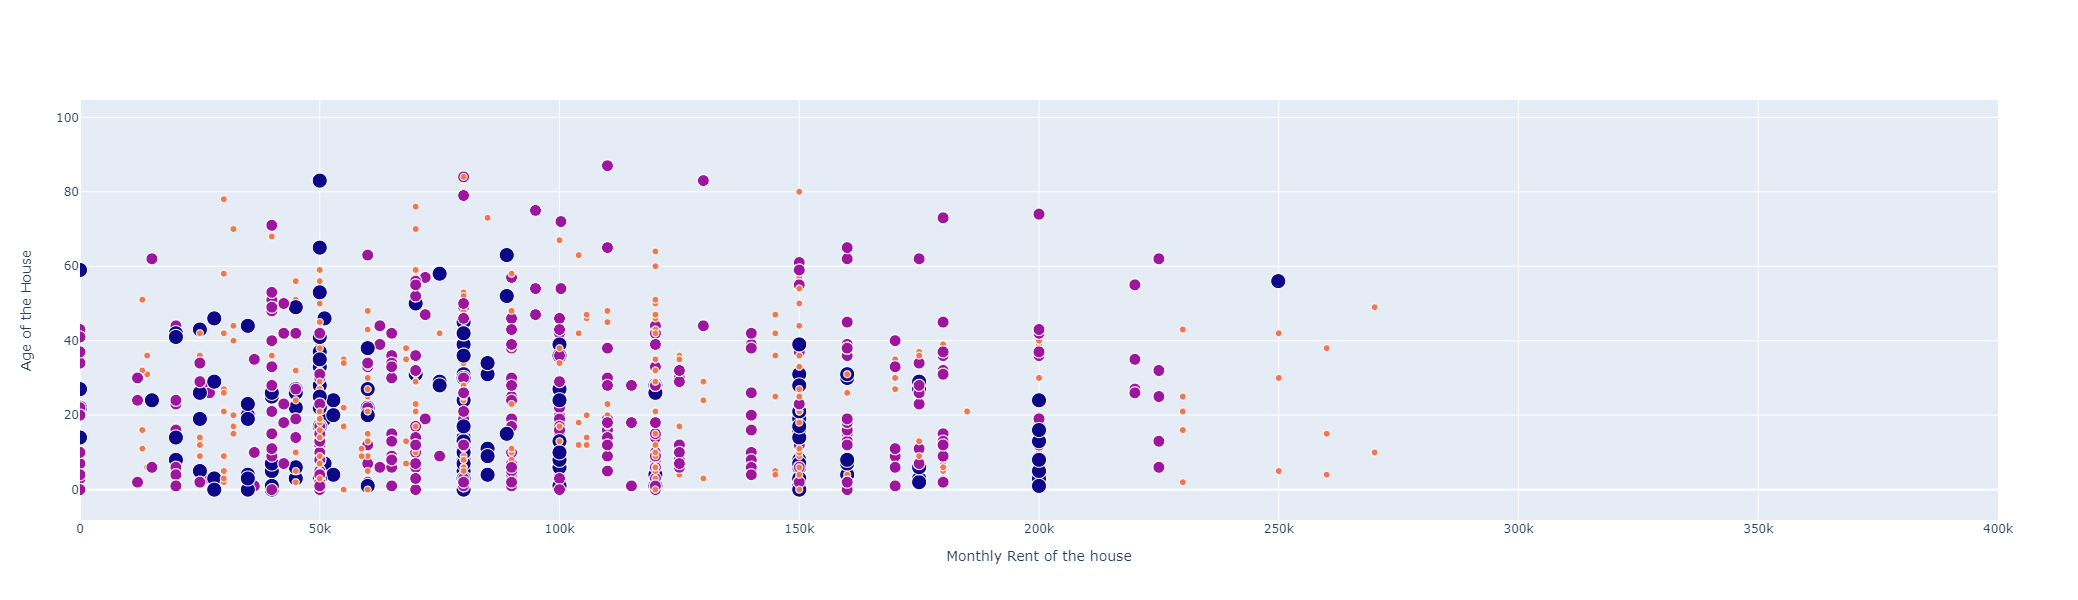

In [15]:
trace0 = go.Scatter(x=train['v2a1'], y=train['age'], name='Exterem', mode='markers', marker=dict(color=train['Target'], opacity=1, size=16-train['Target']**2))

layout = go.Layout(xaxis=dict(title="Monthly Rent of the house", range=(0,400000)), yaxis=dict(title="Age of the House"), height=600, width=800)

fig = go.Figure(data=[trace0], layout=layout)
iplot(fig)

#### 3.6.3 Poverty Levels with respect to Number of Rooms and People Living

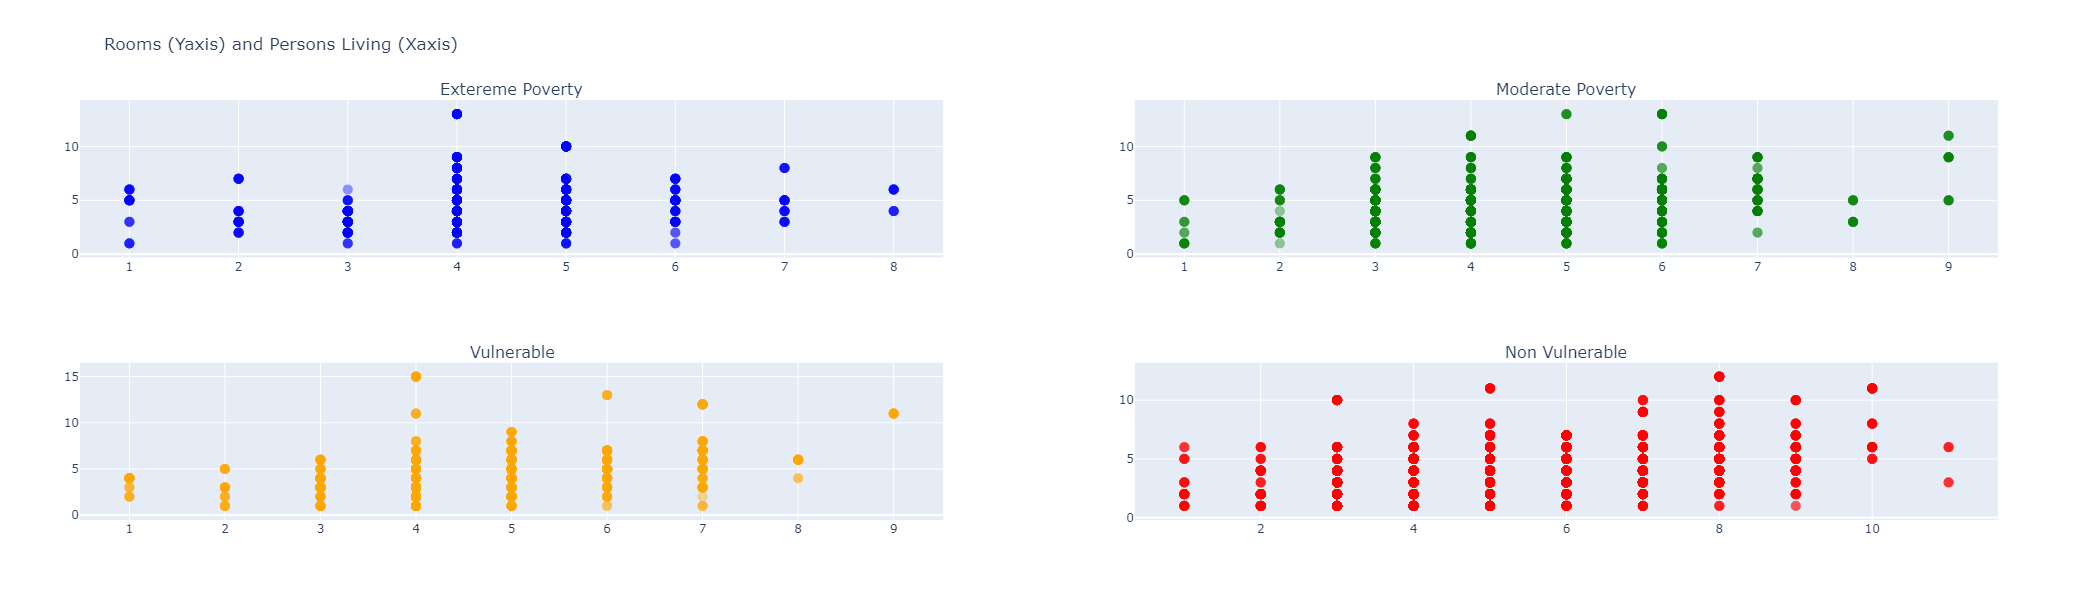

In [16]:
train1 = train[train['Target'] == 1]
train2 = train[train['Target'] == 2]
train3 = train[train['Target'] == 3]
train4 = train[train['Target'] == 4]

trace0 = go.Scatter(x=train1['rooms'], y=train1['tamviv'], name="Extereme", mode='markers', marker=dict(color="blue", opacity=0.4, size=10))
trace1 = go.Scatter(x=train2['rooms'], y=train2['tamviv'], name="Moderate", mode='markers', marker=dict(color="green",opacity=0.4, size=10))
trace2 = go.Scatter(x=train3['rooms'], y=train3['tamviv'], name="Vulnerable", mode='markers', marker=dict(color="orange",opacity=0.4, size=10))
trace3 = go.Scatter(x=train4['rooms'], y=train4['tamviv'], name="NonVulnerable", mode='markers', marker=dict(color="red",opacity=0.4, size=10))

fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "Non Vulnerable"])

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig['layout'].update(height=600, width=1000, showlegend=False, title="Rooms (Yaxis) and Persons Living (Xaxis)" )
iplot(fig)

#### 3.6.4 Distributions (Poverty Levels wise) of some continuous variables

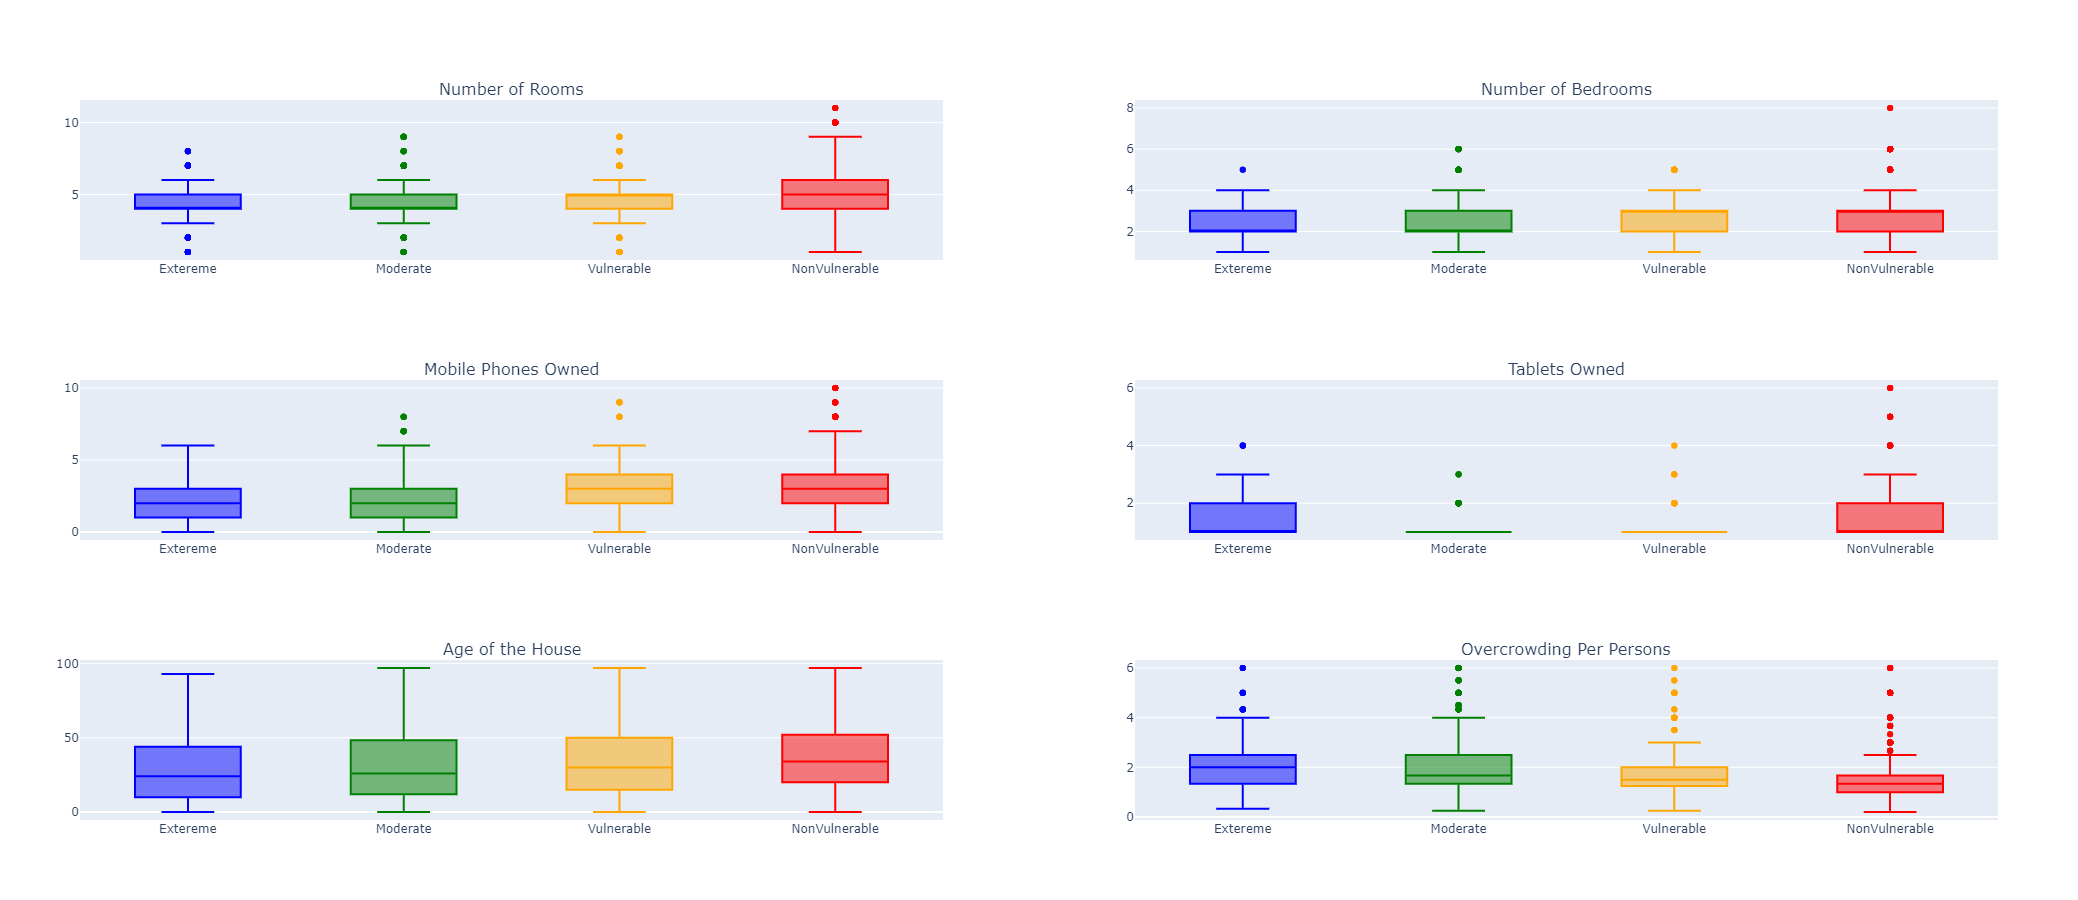

In [17]:
def boxs(col, title):
    y1 = train[train['Target'] == 1][col]
    y2 = train[train['Target'] == 2][col]
    y3 = train[train['Target'] == 3][col]
    y4 = train[train['Target'] == 4][col]
    
    trace1 = go.Box(y=y1, name="Extereme", marker=dict(color="blue", opacity=0.7))
    trace2 = go.Box(y=y2, name="Moderate", marker=dict(color="green", opacity=0.7))
    trace3 = go.Box(y=y3, name="Vulnerable", marker=dict(color="orange", opacity=0.7))
    trace4 = go.Box(y=y4, name="NonVulnerable", marker=dict(color="red", opacity=0.7))
    
    data = [trace1, trace2, trace3, trace4]
    
    return data
    layout = dict(title=title, showlegend=False, height=400)
    data = [trace1, trace2, trace3, trace4]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
titles = ["Number of Rooms", "Number of Bedrooms", "Mobile Phones Owned", "Tablets Owned", "Age of the House", "Overcrowding Per Persons"]
fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)

res = boxs("rooms", "Number of ")
for x in res:
    fig.append_trace(x, 1, 1)
res = boxs("bedrooms", "Number of ")
for x in res:
    fig.append_trace(x, 1, 2)
res = boxs("qmobilephone", "Number of")
for x in res:
    fig.append_trace(x, 2, 1)
res = boxs("v18q1", "Number of")
for x in res:
    fig.append_trace(x, 2, 2)
res = boxs("age", "Number of")
for x in res:
    fig.append_trace(x, 3, 1)
res = boxs("overcrowding", "Number of")
for x in res:
    fig.append_trace(x, 3, 2)

fig['layout'].update(height=900, width=1000, title="", barmode="stack", showlegend=False)
iplot(fig)

### 3.7 Area / Location Detailes

#### 3.7.1 AreaType with respect to Poverty Levels

In [19]:
trgt = {1:'Extereme Poverty', 2:'Moderate Poverty', 3: 'Vulnerable Households', 4:'Non Vulnerable Households'}
train['target'] = train['Target'].apply(lambda x : trgt[x])
train['area_type'] = train['area1'].apply(lambda x: 'urbal' if x==1 else 'rural')

cols = ['area_type', 'target']
colmap = sns.light_palette('yellow', as_cmap=True)
pd.crosstab(train[cols[1]], train[cols[0]]).style.background_gradient(cmap = colmap)

#### 3.7.2 Region with respect to Poverty Levels

In [20]:
cols = ['region', 'target']
colmap = sns.light_palette("orange", as_cmap=True)
pd.crosstab(train[cols[1]], train[cols[0]]).style.background_gradient(cmap = colmap)

## 4. Modeling

### 4.1 Baseline Model

#### 4.1.1 Dataset Preparation - Features and Target Variable

In [30]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# list of features to be used
features = [c for c in train.columns if c not in ['Id', 'Target']]

# target variable
target = train['Target'].values
target_index = {1:0, 2:1, 3:2, 4:3}
target = np.array([target_idnex[c] for c in target])

In [31]:
target

array([3, 3, 3, ..., 1, 1, 1])

#### 4.1.2 Label Encode the categorical variables

In [32]:
train._get_numeric_data().columns

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=138)

In [33]:
def label_encoding(col):
    le = LabelEncoder()
    le.fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    
num_cols = train._get_numeric_data().columns
cat_cols = list(set(features) - set(num_cols))
for col in cat_cols:
    label_encoding(col)

#### 4.1.3 Prepare Training and Validation Sets

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(train[features].values, target, test_size=0.2, random_state=1)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

#### 4.1.4 Baseline LightGBM

In [35]:
params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
          'num_class': 4, 'max_depth': 44, 'num_leaves': 36, 'learning_rate': 0.01,
          'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5,
          'lambda_l2': 1.0, 'verbose': -1, 'num_threads': -1 }

model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=2000, verbose_eval=100)

Training until validation scores don't improve for 2000 rounds
[100]	training's multi_logloss: 0.659211	valid_1's multi_logloss: 0.71211
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.659211	valid_1's multi_logloss: 0.71211


#### 4.1.5 Predict and Submit

In [36]:
# predictions
preds = model.predict(test[features], num_iteration=model.best_iteration)

# revert back to original classes
reverse_index = {}
for k, v in target_index.items():
    reverse_index[v] = k
preds = [reverse_index[np.argmax(p)] for p in preds]

# submission
subs = pd.DataFrame()
subs['Id'] = test['Id']
subs['Target'] = preds
subs.to_csv('submission.csv', index=False)

subs.head()

Id  Target
0  ID_2f6873615       4
1  ID_1c78846d2       4
2  ID_e5442cf6a       4
3  ID_a8db26a79       4
4  ID_a62966799       4